### Load necessary files and packages

In [1]:
from google.colab import files
uploaded = files.upload()

Saving trainPart1.zip to trainPart1.zip
Saving train-labels-idx1-ubyte.gz to train-labels-idx1-ubyte.gz
Saving train-images-idx3-ubyte.gz to train-images-idx3-ubyte.gz
Saving t10k-labels-idx1-ubyte.gz to t10k-labels-idx1-ubyte.gz
Saving t10k-images-idx3-ubyte.gz to t10k-images-idx3-ubyte.gz


In [ ]:
!unzip trainPart1.zip

In [ ]:
!gunzip t10k-labels-idx1-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!gunzip train-images-idx3-ubyte.gz

!pip install idx2numpy

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from sklearn.preprocessing import LabelEncoder

### Create Dataset

In [2]:
ROOT_DIR = 'train'
labels = []
images = []
all_labels = sorted(os.listdir(ROOT_DIR))
for i in range(10):
  label = all_labels[i]
  path = [os.path.join(ROOT_DIR, label, p) for p in os.listdir(os.path.join(ROOT_DIR, label))]
  for p in path:
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28, 28))
    images.append(image)
    labels.append(i)

In [3]:
images = np.asarray(images)/255
images = np.expand_dims(images, -1)
labels = np.asarray(labels)

In [4]:
images.shape, labels.shape

((400, 28, 28, 1), (400,))

As the number of total samples in the dataset is very less, i.e. 2,480, more samples are created by Data Augmentation techniques. <br />
Random Translation and Rotation is done to create new data sample

In [5]:
data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.1, 0.1), (-0.1, 0.1)),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)])

augmented_dataset = None

for i in range(25):
  augmented_image = data_augmentation(images)
  if augmented_dataset is None:
    augmented_dataset = augmented_image
    augmented_labels = labels
  else:
    augmented_dataset = np.vstack([augmented_dataset, augmented_image])
    augmented_labels = np.hstack([augmented_labels, labels])

### Train-Test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(augmented_dataset, augmented_labels, test_size=0.2, random_state=42)

In [10]:
x_train.shape

(8000, 28, 28, 1)

### Model Creation & Training

In [11]:
def Model(image, label, dropout=0.25):
  _input = tf.keras.layers.Input(shape=image)

  x = tf.keras.layers.Conv2D(16, (3, 3))(_input)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(32, (3, 3))(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(64, (3, 3))(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  # x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(256)(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(label)(x)
  x = tf.keras.layers.Activation(tf.nn.softmax)(x)
  return tf.keras.Model(_input, x)

Summary of the model

In [12]:
model = Model(x_train[0].shape, 10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640  

In [13]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_pretrained/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = model.fit(x_train, y_train, validation_split=0.25, epochs=150, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/150
24/24 [==============================] - 34s 37ms/step - loss: 2.5069 - accuracy: 0.2503 - val_loss: 2.3619 - val_accuracy: 0.1015
Epoch 2/150
24/24 [==============================] - 0s 10ms/step - loss: 1.5338 - accuracy: 0.4881 - val_loss: 2.7241 - val_accuracy: 0.1015
Epoch 3/150
24/24 [==============================] - 0s 10ms/step - loss: 1.1694 - accuracy: 0.6129 - val_loss: 3.5014 - val_accuracy: 0.1015
Epoch 4/150
24/24 [==============================] - 0s 10ms/step - loss: 0.9551 - accuracy: 0.6799 - val_loss: 4.3042 - val_accuracy: 0.1015
Epoch 5/150
24/24 [==============================] - 0s 11ms/step - loss: 0.7925 - accuracy: 0.7258 - val_loss: 4.6205 - val_accuracy: 0.1015
Epoch 6/150
24/24 [==============================] - 0s 10ms/step - loss: 0.7095 - accuracy: 0.7574 - val_loss: 8.0543 - val_accuracy: 0.1015
Epoch 7/150
24/24 [==============================] - 0s 11ms/step - loss: 0.5936 - accuracy: 0.7965 - val_loss: 6.9414 - val_accuracy: 0.1015
Epoch

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

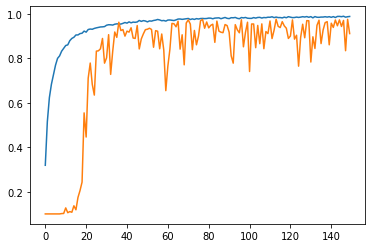

In [14]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

Load the model with best weights for evaluation

In [15]:
model.load_weights('weights_pretrained/')
print("Train Accuracy:", model.evaluate(x_train, y_train, verbose=0)[1], "Test Accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Train Accuracy: 0.9931250214576721 Test Accuracy: 0.9779999852180481


### Train on pre-trained model

In [16]:
import idx2numpy
file = 'train-images-idx3-ubyte'
x_train = np.expand_dims(idx2numpy.convert_from_file(file), -1)

file = 'train-labels-idx1-ubyte'
y_train = np.expand_dims(idx2numpy.convert_from_file(file), -1)

file = 't10k-images-idx3-ubyte'
x_test = idx2numpy.convert_from_file(file)

file = 't10k-labels-idx1-ubyte'
y_test = idx2numpy.convert_from_file(file)

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 1))

In [17]:
model.load_weights("weights_pretrained/")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='MNIST_pretrained/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = model.fit(x_train, y_train, validation_split=0.25, epochs=5, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/5
176/176 [==============================] - 3s 12ms/step - loss: 0.3134 - accuracy: 0.9311 - val_loss: 0.0963 - val_accuracy: 0.9723
Epoch 2/5
176/176 [==============================] - 2s 9ms/step - loss: 0.0825 - accuracy: 0.9750 - val_loss: 0.0605 - val_accuracy: 0.9800
Epoch 3/5
176/176 [==============================] - 2s 9ms/step - loss: 0.0617 - accuracy: 0.9806 - val_loss: 0.0763 - val_accuracy: 0.9775
Epoch 4/5
176/176 [==============================] - 2s 10ms/step - loss: 0.0516 - accuracy: 0.9843 - val_loss: 0.0476 - val_accuracy: 0.9852
Epoch 5/5
176/176 [==============================] - 2s 10ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.0464 - val_accuracy: 0.9859


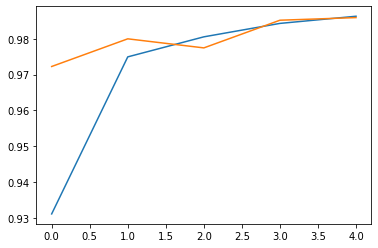

In [18]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

In [19]:
print("Test Accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Test Accuracy: 0.9882000088691711


### Train on Randomly Initialized Network

In [20]:
model = Model(x_train[0].shape, 10)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='MNIST/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = model.fit(x_train, y_train, validation_split=0.25, epochs=5, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/5
176/176 [==============================] - 3s 11ms/step - loss: 0.5020 - accuracy: 0.8482 - val_loss: 0.1100 - val_accuracy: 0.9681
Epoch 2/5
176/176 [==============================] - 2s 9ms/step - loss: 0.0971 - accuracy: 0.9696 - val_loss: 0.1450 - val_accuracy: 0.9584
Epoch 3/5
176/176 [==============================] - 2s 9ms/step - loss: 0.0697 - accuracy: 0.9790 - val_loss: 0.0970 - val_accuracy: 0.9696
Epoch 4/5
176/176 [==============================] - 2s 9ms/step - loss: 0.0566 - accuracy: 0.9820 - val_loss: 0.1154 - val_accuracy: 0.9667
Epoch 5/5
176/176 [==============================] - 2s 9ms/step - loss: 0.0506 - accuracy: 0.9838 - val_loss: 0.1094 - val_accuracy: 0.9682


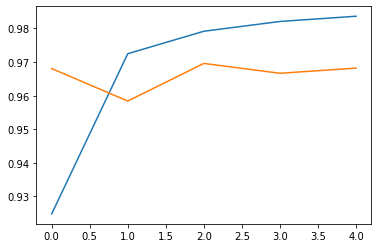

In [21]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

In [22]:
print("Test Accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Test Accuracy: 0.9702000021934509
